### Librairies

In [1]:
!conda info

Traceback (most recent call last):
  File "/usr/bin/conda", line 33, in <module>
    sys.exit(load_entry_point('conda==4.1.6', 'console_scripts', 'conda')())
  File "/usr/lib/python3.10/site-packages/conda/cli/main.py", line 94, in main
    imported = importlib.import_module(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/lib/python3.10/site-packages/conda/cli/main_list.py", line 18, in <module>
    from ..egg_info import get_egg_info
  File "/us

### Librairies
-----------------------------

In [57]:
import requests
import lxml.html as lh
import pandas as pd
from wordcloud import WordCloud
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/perrine/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Récupération des données : webscrapping
------------------------

In [3]:
# URL
url_inception = 'https://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/'
url_sonic = 'https://www.allocine.fr/film/fichefilm-281203/critiques/spectateurs/'
# URI-SUFFIX
uri_pages = '?page='
# Number of pages to read
nbPages = 100

tags = ['//span[@class="stareval-note"]', \
       '//div[@class="content-txt review-card-content"]']
cols = ['Note', \
        'Commentaire']

In [4]:
def get_page(url):
    page = requests.get(url)
    doc = lh.fromstring(page.content)
    
    #Get the web data via xpath
    content = []
    for i in range(len(tags)):
        content.append(doc.xpath(tags[i]))
    
    # Gather the data into a Pandas DataFrame array
    df_liste = []
    for j in range(len(tags)):
        tmp = pd.DataFrame([content[j][i].text_content().strip() for i in range(len(content[i]))], columns=[cols[j]])
        tmp['key'] = tmp.index
        df_liste.append(tmp)
 
    # Build the unique Dataframe with one tag (xpath) content per column
    liste = df_liste[0]
    for j in range(len(tags)-1):
        liste = liste.join(df_liste[j+1], on='key', how='left', lsuffix='_l', rsuffix='_r')
        liste['key'] = liste.index
        del liste['key_l']
        del liste['key_r']
 
    return liste        

In [5]:
def getPages(_nbPages, _url):
    liste_finale = pd.DataFrame()
    for i in range (_nbPages):
        liste = get_page(_url + uri_pages + str(i+1))
        liste_finale = pd.concat([liste_finale, liste], ignore_index=True)
    return liste_finale
 
df_inception = getPages(nbPages, url_inception)

In [6]:
df_inception.head()

,Note,Commentaire,key
0,"5,0",Après le chef d'oeuvre super-héroïque The Dark...,0
1,"5,0",C’est fou ce qu’on aime détester Christopher N...,1
2,"5,0",CHEF D’ŒUVRE ! Le film est absolument parfait ...,2
3,"5,0","Un film aussi novateur que complexe, dont la m...",3
4,"3,5",Le meilleur blockbuster de 2010 a pour thème l...,4


In [7]:
df_sonic = getPages(nbPages, url_sonic)
df_sonic.head()

,Note,Commentaire,key
0,"5,0",Cette suite de sonic est incroyable !Le fan qu...,0
1,"4,0",une bonne suite pour les aventures de sonic au...,1
2,"3,0",Malgré deux nouveaux personnages de l'univers ...,2
3,"4,0",Très bon film ont retrouve ce qui fait l’espri...,3
4,"4,0","Super film de ouf, le fait que Knuckles soit d...",4


### Concaténation des dataframes

In [8]:
df_sonic.shape

(1045, 3)

In [9]:
df_inception.shape

(1500, 3)

In [10]:
df_films = pd.concat([df_sonic, df_inception])

In [11]:
df_films.reset_index(inplace=True)

In [13]:
df_films.tail()

,index,Note,Commentaire,key
2540,1495,"4,0",Un film dans le monde des rêves avec un soupço...,10
2541,1496,"0,5",scénario sans consistance et acteur principal ...,11
2542,1497,"5,0",tout bonnement fabuleux ! ce film est une pure...,12
2543,1498,"4,5",Ce film est d'une réflexion et d'une Originali...,13
2544,1499,"2,5",Agréablement surpris! Des effets spéciaux impr...,14


In [14]:
df_films.shape

(2545, 4)

### Pre-processing : nettoyage des commentaires
---------------------

#### Elimination de la ponctuation (regex) et transformation en minuscule

In [15]:
df_films['Commentaire'] = df_films['Commentaire'].replace("[^\w\s]", " ", regex = True).str.replace("\d+", '', regex=True).str.lower()

In [16]:
df_films.head()

,index,Note,Commentaire,key
0,0,"5,0",cette suite de sonic est incroyable le fan qu...,0
1,1,"4,0",une bonne suite pour les aventures de sonic au...,1
2,2,"3,0",malgré deux nouveaux personnages de l univers ...,2
3,3,"4,0",très bon film ont retrouve ce qui fait l espri...,3
4,4,"4,0",super film de ouf le fait que knuckles soit d...,4


#### Suppression des stop words

In [17]:
SW = stopwords.words('french')
df_films['Commentaire_sans_SW'] = df_films['Commentaire'].apply(lambda x:' '.join([word for word in x.split() if word not in SW]))


In [18]:
df_films

,index,Note,Commentaire,key,Commentaire_sans_SW
0,0,"5,0",cette suite de sonic est incroyable le fan qu...,0,cette suite sonic incroyable fan ravi quand jo...
1,1,"4,0",une bonne suite pour les aventures de sonic au...,1,bonne suite aventures sonic cinéma deja premie...
2,2,"3,0",malgré deux nouveaux personnages de l univers ...,2,malgré deux nouveaux personnages univers jeu v...
3,3,"4,0",très bon film ont retrouve ce qui fait l espri...,3,très bon film retrouve fait esprit sonic film ...
4,4,"4,0",super film de ouf le fait que knuckles soit d...,4,super film ouf fait knuckles côté eggman début...
...,...,...,...,...,...
2540,1495,"4,0",un film dans le monde des rêves avec un soupço...,10,film monde rêves soupçon film action apocalypt...
2541,1496,"0,5",scénario sans consistance et acteur principal ...,11,scénario sans consistance acteur principal peu...
2542,1497,"5,0",tout bonnement fabuleux ce film est une pure...,12,tout bonnement fabuleux film pure merveille al...
2543,1498,"4,5",ce film est d une réflexion et d une originali...,13,film réflexion originalité inégalable si film ...


#### Lemmentiser

In [19]:
import spacy
nlp = spacy.load('fr_core_news_md')

2022-06-07 15:09:23.300278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 15:09:23.300427: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [20]:
df_films['lemmatizer'] = df_films['Commentaire_sans_SW'].apply(lambda x: [y.lemma_ for y in nlp(x)])

In [21]:
df_films.head()

,index,Note,Commentaire,key,Commentaire_sans_SW,lemmatizer
0,0,"5,0",cette suite de sonic est incroyable le fan qu...,0,cette suite sonic incroyable fan ravi quand jo...,"[ce, suite, sonic, incroyable, fan, ravir, qua..."
1,1,"4,0",une bonne suite pour les aventures de sonic au...,1,bonne suite aventures sonic cinéma deja premie...,"[bon, suite, aventure, sonic, cinéma, deja, pr..."
2,2,"3,0",malgré deux nouveaux personnages de l univers ...,2,malgré deux nouveaux personnages univers jeu v...,"[malgré, deux, nouveau, personnage, univer, je..."
3,3,"4,0",très bon film ont retrouve ce qui fait l espri...,3,très bon film retrouve fait esprit sonic film ...,"[très, bon, film, retrouve, faire, esprit, son..."
4,4,"4,0",super film de ouf le fait que knuckles soit d...,4,super film ouf fait knuckles côté eggman début...,"[super, film, ouf, faire, knuckles, côté, eggm..."


##### Transformation des listes dans la colonne "lemmatizer" en chaine de caractères

In [22]:
df_films['lemmatizer'] = df_films["lemmatizer"].apply(lambda x: ' '.join(str(y) for y in x))
df_films.head()

,index,Note,Commentaire,key,Commentaire_sans_SW,lemmatizer
0,0,"5,0",cette suite de sonic est incroyable le fan qu...,0,cette suite sonic incroyable fan ravi quand jo...,ce suite sonic incroyable fan ravir quand joue...
1,1,"4,0",une bonne suite pour les aventures de sonic au...,1,bonne suite aventures sonic cinéma deja premie...,bon suite aventure sonic cinéma deja premier f...
2,2,"3,0",malgré deux nouveaux personnages de l univers ...,2,malgré deux nouveaux personnages univers jeu v...,malgré deux nouveau personnage univer jeu vidé...
3,3,"4,0",très bon film ont retrouve ce qui fait l espri...,3,très bon film retrouve fait esprit sonic film ...,très bon film retrouve faire esprit sonic film...
4,4,"4,0",super film de ouf le fait que knuckles soit d...,4,super film ouf fait knuckles côté eggman début...,super film ouf faire knuckles côté eggman débu...


#### Remplacement des accents

In [23]:
df_films['lemmatizer'] = df_films['lemmatizer'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [195]:
df_films.head()

,index,Note,Commentaire,key,Commentaire_sans_SW,lemmatizer
0,0,"5,0",cette suite de sonic est incroyable le fan qu...,0,cette suite sonic incroyable fan ravi quand jo...,ce suite sonic incroyable fan ravir quand joue...
1,1,"4,0",une bonne suite pour les aventures de sonic au...,1,bonne suite aventures sonic cinéma deja premie...,bon suite aventure sonic cinema deja premier f...
2,2,"3,0",malgré deux nouveaux personnages de l univers ...,2,malgré deux nouveaux personnages univers jeu v...,malgre deux nouveau personnage univer jeu vide...
3,3,"4,0",très bon film ont retrouve ce qui fait l espri...,3,très bon film retrouve fait esprit sonic film ...,tres bon film retrouve faire esprit sonic film...
4,4,"4,0",super film de ouf le fait que knuckles soit d...,4,super film ouf fait knuckles côté eggman début...,super film ouf faire knuckles cote eggman debu...


#### Stemmatiser

In [25]:
#Méthode non utilisé pour éviter de perdre le sens des mots
#stemmer = SnowballStemmer("french")
#df_films['stemmed'] = df_films['Commentaire_sans_SW'].str.split().apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
#df_films.head()

#### Définition des features et de la target

In [26]:
X = df_films['lemmatizer']
y = df_films['Note'].replace(',', '.', regex=True).astype('float')

y.dtype

dtype('float64')

In [27]:
y = y.mask(y<3.0, 0)
y = y.mask(y>=3.0, 1)

y.value_counts()

1.0    2226
0.0     319
Name: Note, dtype: int64

#### Fractionnement du jeu de données en train et test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print(y_train.value_counts())
print(y_test.value_counts())

1.0    1781
0.0     255
Name: Note, dtype: int64
1.0    445
0.0     64
Name: Note, dtype: int64


In [29]:
y_train.shape

(2036,)

In [30]:
y_test.shape

(509,)

#### Data augmentation par remplacement de synonymes

In [196]:
import nlpaug.augmenter.word as naw
aug = naw.SynonymAug(aug_src='wordnet', lang='fra', aug_min=10)

#Test
X_train.iloc[0]

'adorer film beaucoup mieux premier loin trop aimer combat entre sonic knuckles beaucoup plus reference rapport sonic sah cela faire plaisirtails toujours mignonj aime aussi moment snowboard ou knuckles raconte passer team sonic reunir let godeath egg robot super realiste donc tant mieuxsuper sonic avoir mettre tout monde accordet scene post credit apparition shadowdonc donner note etoile regarder sonic film'

In [197]:
augmented = aug.augment(X_train.iloc[0])

augmented

'adorer film beaucoup mieux premier loin trop aimer combat entre sonic knuckles beaucoup plus reference rapport sonic sah cela faire plaisirtails toujours mignonj aime aussi moment snowboard ou knuckles raconte passer team sonic reunir let godeath egg robot super realiste donc tant mieuxsuper sonic avoir mettre tout planète accordet scene post credit apparition shadowdonc donner distinction etoile regarder sonic film'

In [198]:
augmented_data = []
for i in X_train[y_train == 0]:
    data_augmented = aug.augment(i)
    augmented_data.append(data_augmented)

len(augmented_data)
augmented_label = np.zeros(len(augmented_data))

In [179]:
#Transformation des listes en Séries
augmented_data = pd.Series(augmented_data)
augmented_label = pd.Series(augmented_label)

In [184]:
#Concaténation du X_train avec la data augmentée et pareil pour le y_train
X_train = pd.concat([X_train, augmented_data])
y_train = pd.concat([y_train, augmented_label])
X_train.shape

In [201]:
y_train.value_counts()

1.0    1781
0.0     765
dtype: int64

In [185]:
#index_neg = y_train[y_train==0].index

#augmented_data = []
#for i in index_neg:
#    print(i)
#    print(X_train.iloc[i])
#    data_augmented = aug.augment(X_train.iloc[i])
    #augmented_data.append(data_augmented)


### Visualisation des avis positifs et négatifs : word cloud
-------------------

In [104]:
df_wc = pd.concat([X, y], axis = 1)
df_wc.head()

,lemmatizer,Note
0,ce suite sonic incroyable fan ravir quand joue...,1.0
1,bon suite aventure sonic cinema deja premier f...,1.0
2,malgre deux nouveau personnage univer jeu vide...,1.0
3,tres bon film retrouve faire esprit sonic film...,1.0
4,super film ouf faire knuckles cote eggman debu...,1.0


#### Avis positifs

In [105]:
#Récupération des avis positifs
avis_positif = df_wc["lemmatizer"][df_wc["Note"] == 1.0]

avis_positif

0       ce suite sonic incroyable fan ravir quand joue...
1       bon suite aventure sonic cinema deja premier f...
2       malgre deux nouveau personnage univer jeu vide...
3       tres bon film retrouve faire esprit sonic film...
4       super film ouf faire knuckles cote eggman debu...
                              ...                        
2538    voir avant premier pathe quai ivry ima film ge...
2539    suite succes interplanetaire the dark knight c...
2540    film monde reve soupcon film action apocalypti...
2542    tout bonnement fabuleux film pur merveille all...
2543    film reflexion originalite inegalable si film ...
Name: lemmatizer, Length: 2226, dtype: object

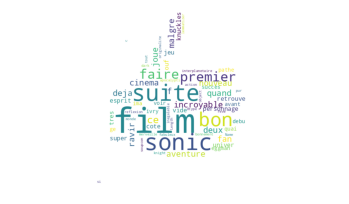

In [106]:
from PIL import Image
import numpy as np

mask_pos = np.array(Image.open("thumb_up.png"))
mask_pos[mask_pos == 1] = 255

WC_pos = WordCloud(background_color="white", mask = mask_pos).generate(str(avis_positif))
plt.imshow(WC_pos)
plt.axis('off')
plt.show()

#### Avis négatifs

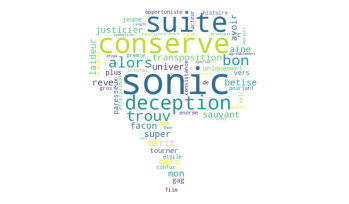

In [107]:
mask_neg = np.array(Image.open("thumb_down.png"))
mask_neg[mask_neg == 1] = 255

WC_neg = WordCloud(background_color="white", mask = mask_neg).generate(str(df_wc["lemmatizer"][df_wc["Note"]==0.0]))
plt.imshow(WC_neg)
plt.axis('off')
plt.show()

In [108]:
df_wc

,lemmatizer,Note
0,ce suite sonic incroyable fan ravir quand joue...,1.0
1,bon suite aventure sonic cinema deja premier f...,1.0
2,malgre deux nouveau personnage univer jeu vide...,1.0
3,tres bon film retrouve faire esprit sonic film...,1.0
4,super film ouf faire knuckles cote eggman debu...,1.0
...,...,...
2540,film monde reve soupcon film action apocalypti...,1.0
2541,scenario sans consistance acteur principal peu...,0.0
2542,tout bonnement fabuleux film pur merveille all...,1.0
2543,film reflexion originalite inegalable si film ...,1.0


### Régression logistique
--------------
#### Count Vectorizer

In [186]:
cv = CountVectorizer(lowercase=False, min_df=0.1)
cv = cv.fit(X_train)
cv_matrix = cv.transform(X_train)
cv_matrix.shape

(2546, 96)

In [187]:
#Create bag of words
X_train_bow = pd.DataFrame(cv_matrix.toarray(), index = X_train.index.values, columns = cv.get_feature_names_out())
X_train_bow

,acteur,action,adorer,aimer,aller,alors,apres,assez,aussi,autre,...,super,tail,temps,toujours,tout,tres,trop,voir,vouloir,vraiment
640,0,0,1,1,0,0,0,0,1,0,...,1,0,0,1,1,0,1,0,0,0
1474,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
869,0,0,0,0,1,1,0,1,0,1,...,0,0,0,0,1,2,0,0,0,1
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0,2,0,0,0,1,1,0,0,1,...,0,0,0,0,1,2,1,1,0,2
251,0,0,0,0,0,0,0,3,1,0,...,0,0,0,1,0,0,0,0,0,0
252,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,2,0,0,0,0
253,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,1,1,0,0


#### Modèle de régression logistique

In [188]:
model_LR = LogisticRegression(solver="liblinear", random_state=0)

#Entrainement du modèle
model_LR.fit(X_train_bow, y_train)

LogisticRegression(random_state=0, solver='liblinear')

#### Conversion du X_test en matrice

In [189]:
#cv2 = CountVectorizer(lowercase=False, min_df=0.1)

cv_X_test = cv.transform(X_test)
cv_X_test.shape

(509, 96)

In [190]:
X_test_bow = pd.DataFrame(cv_X_test.toarray(), index = X_test.index, columns = cv.get_feature_names_out())
X_test_bow

,acteur,action,adorer,aimer,aller,alors,apres,assez,aussi,autre,...,super,tail,temps,toujours,tout,tres,trop,voir,vouloir,vraiment
2086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
766,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1787,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1931,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694,3,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,1,1,0
2311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2502,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [191]:
#Prédiction du y
y_pred = model_LR.predict(X_test_bow)

#### Accuracy

In [192]:
accuracy = model_LR.score(X_test_bow, y_test)
print(f"La précision est de {accuracy}")

La précision est de 0.8467583497053045


#### Matrice de confusion

In [193]:
matrice_confusion = confusion_matrix(y_test, y_pred)
matrice_confusion

array([[ 41,  23],
       [ 55, 390]])

In [194]:
tn, fp, fn, tp = matrice_confusion.ravel()

print(f"True negative = {tn}, \nFalse positive = {fp}, \nFalse negative = {fn}, \nTrue positive = {tp}")

True negative = 41, 
False positive = 23, 
False negative = 55, 
True positive = 390


### Word embedding
---------------------

In [44]:
from gensim.models import Word2Vec, KeyedVectors #To load the model
import warnings
warnings.filterwarnings('ignore') #ignore any generated warnings
import os
from sklearn.manifold import TSNE #scikit learn's TSNE 

In [48]:
# Load the model
try:
    #import google.colab
    model = KeyedVectors.load_word2vec_format('word2vec_cbow.bin',binary=True)
except ModuleNotFoundError:
    cwd=os.getcwd() 
    model = KeyedVectors.load_word2vec_format(cwd+'\Models\word2vec_cbow.bin', binary=True)

In [73]:
#Récupération de tous les mots lemmantisés dans une liste
lem_words = []
for i in df_wc['lemmatizer']:
    for j in i.split():
        lem_words.append(j)
len(lem_words)

137205

In [58]:
model.most_similar(positive=['negative', 'bird'], negative=['man'], topn = 1)

[('localized', 0.5681970715522766)]

In [59]:
keys = ['positive', 'negative', 'film']
#keys = ['school', 'year', 'college', 'city', 'states', 'university', 'team', 'film']
embedding_cluster = []
words_cluster = []

for word in keys :
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_cluster.append(embeddings) #apending access vector of all similar words
    words_cluster.append(words) #appending list of all smiliar words

In [81]:
print("Embedding clusters:",embedding_cluster[0][0])#Access vector of the first word only
print("Word Clusters:",words_cluster[:2])


Embedding clusters: [ 0.36088547 -3.1332264  -0.06153435 -0.61246485 -0.80768806 -0.8371202
  1.0593033   0.3068827   1.6431762   0.7520422   2.1674433  -1.9197233
 -0.79090387  1.1006339  -1.7400944   0.8813881   1.3174818   0.94298893
  0.06689654 -1.0822556  -0.10947102 -1.8360969  -2.3878515   0.21770738
 -2.3002317   2.419421   -0.9591381  -3.4237325   2.9981098  -4.0774493
  0.01078644  0.84831595 -0.96117043  0.63802284 -0.35265294 -0.28235444
  0.7301104  -1.974097    1.9789728   2.2485085  -0.39138255 -1.7413374
  0.35678783 -1.7168614  -0.5658367   3.798959   -0.3051753   0.7108856
 -0.23381627  2.693441    0.8875558   0.26892227  0.13772608  0.48111036
 -1.1024251  -1.217945   -1.3157183  -1.1661698   0.6784949   2.6282861
  3.8881588   1.3265886   1.6789842   3.4789982  -1.0287496   3.0636985
  1.7191972   1.4072284   1.4234765  -1.3009055  -1.2499199   0.03651512
 -2.2455788   0.30492812  0.34724063 -0.43861753  1.0137143   0.42935792
 -1.3615006  -0.1817193   1.9507194  -

In [61]:
from sklearn.manifold import TSNE

In [63]:
embedding_cluster = np.array(embedding_cluster)
n, m, k = embedding_cluster.shape
tsne_model_en_2D = TSNE(perplexity=5, n_components = 2, init='pca', n_iter = 1500, random_state=2020)
embedding_en_2D = np.array(tsne_model_en_2D.fit_transform(embedding_cluster.reshape(n*m, k))).reshape(n, m, 2)

In [87]:
a = ['a', 'b', 'c']
b = [[1, 2, 3], [2, 3, 4], [3, 4, 5]]

for i, j in zip(a, b):
    print(i)
    print(j)


a
[1, 2, 3]
b
[2, 3, 4]
c
[3, 4, 5]


In [98]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#script for constructing two-dimensional graphics using Matplotlib
def tsne_plot_similar_words(labels, embeddings_clusters, words_clusters, a=0.7):
    plt.figure(figsize=(16,9))
    
    for label, embeddings, words in zip(labels, embeddings_clusters, words_clusters):
        print(len(labels))
        print(label)
        print(len(embeddings_clusters))
        print(len(words_clusters))
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, alpha=a, label = label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha = 0.5, xy=(x[i], y[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom', size=8)
        
    plt.legend(loc=4)
    plt.grid(False)
    plt.show()


137205
bon
3
3
137205
suite
3
3
137205
aventure
3
3


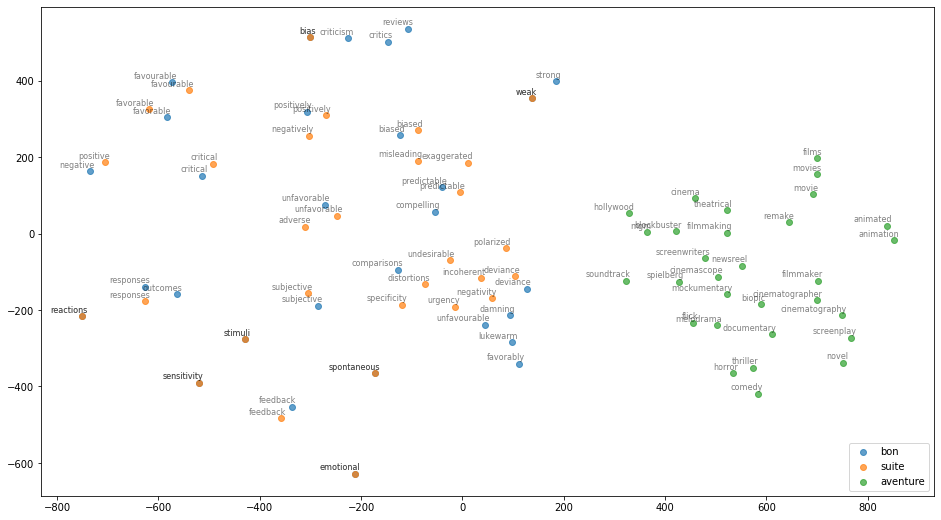

In [99]:
tsne_plot_similar_words(lem_words, embedding_en_2D, words_cluster)

### Clustering des mots

In [100]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

#### Features extractions : TF-IDF

In [101]:
vec = TfidfVectorizer()
vec.fit(df_wc['lemmatizer'])
features = vec.transform(df_wc['lemmatizer'])

In [118]:
cls = MiniBatchKMeans(n_clusters=2, random_state=0)
cls.fit(features)


MiniBatchKMeans(n_clusters=2, random_state=0)

In [120]:
# predict cluster labels for new dataset
y_predict = cls.predict(features)


In [121]:
#reduce dimensions to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(features.toarray())

#reduce the cluster center to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)


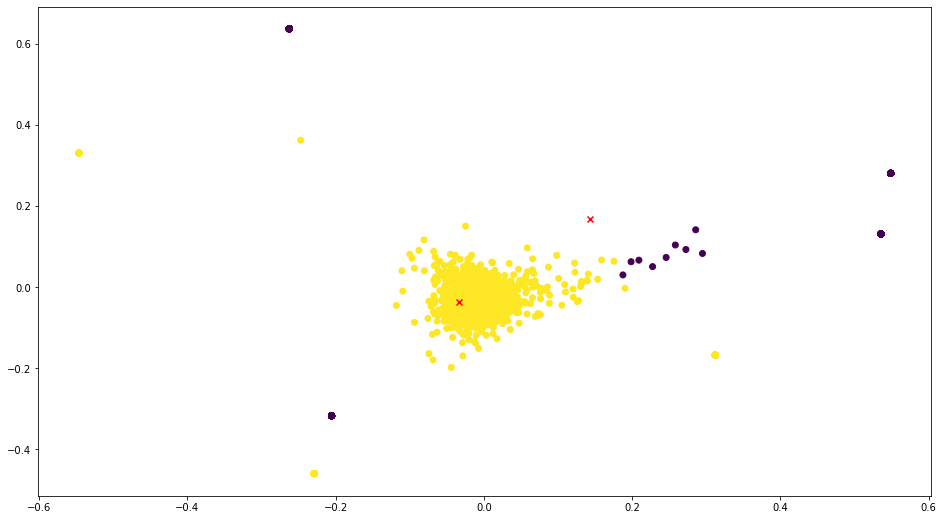

In [122]:
plt.figure(figsize=(16,9))
plt.scatter(reduced_features[:,0], reduced_features[:, 1], c = y_predict)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], marker = 'x', c='red')
plt.show()

#### Evaluation du modèle

In [123]:
from sklearn.metrics import homogeneity_score

In [124]:
homogeneity_score(df_wc['Note'], y_predict)

0.06797275329471977

#### Test d'un word cloud

In [52]:
com_1 = df_sonic.iloc[0, 1]

In [64]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/perrine/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [74]:

SW = stopwords.words('french')
#SW.append('Cette')
#SW.append('fille')
sw2 = ['déjà', 'formeune', 'toute', 'trop', 'suite']

In [72]:
for i in sw2:
    SW.append(i)

In [73]:
print(SW)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

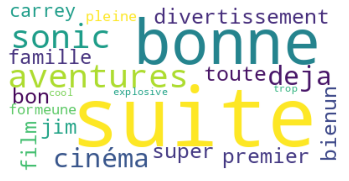

In [67]:

WC=WordCloud(background_color = 'white',stopwords = SW).generate(com_1)

plt.imshow(WC)
plt.axis("off")
plt.show()